# Assignment 9

Data Analytics III

1. Implement Simple Naïve Bayes classification algorithm using Python/R on iris.csv dataset.
2. Compute Confusion matrix to find TP, FP, TN, FN, Accuracy, Error rate, Precision, Recall on the given dataset. Provide the codes with outputs and explain everything that you do in this step.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [2]:
# Load the Iris dataset
df = pd.read_csv('Iris.csv')

In [3]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


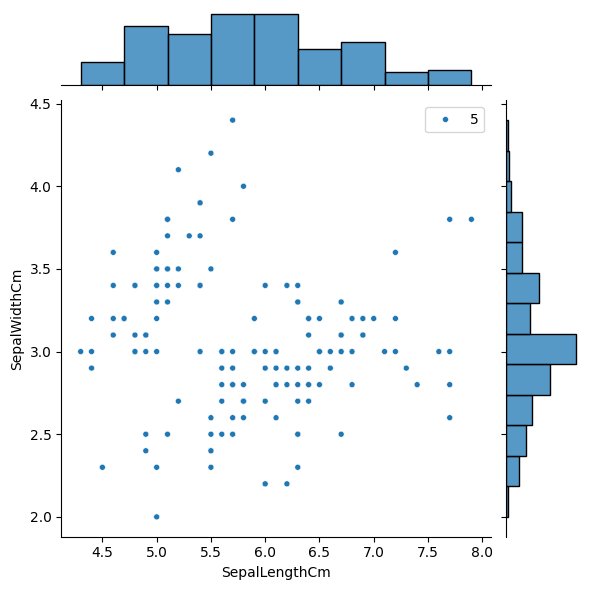

In [4]:
sns.jointplot(x="SepalLengthCm", y="SepalWidthCm", data=df, size=5)
plt.show()

/tmp/ipykernel_3590/597332757.py:2: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax= sns.stripplot(x="Species", y="PetalLengthCm", data=df, jitter=True, edgecolor="gray")


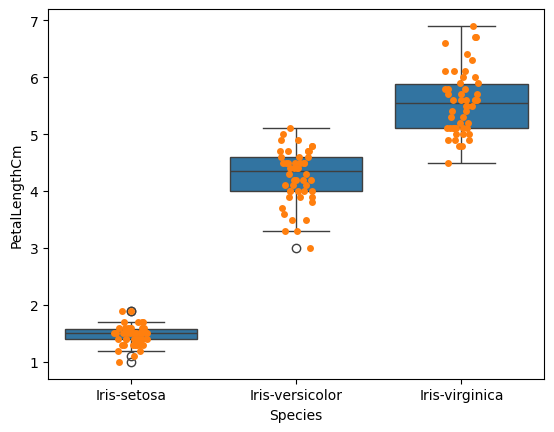

In [5]:
ax= sns.boxplot(x="Species", y="PetalLengthCm", data=df)
ax= sns.stripplot(x="Species", y="PetalLengthCm", data=df, jitter=True, edgecolor="gray")
plt.show()

In [6]:
features = df.iloc[:, :-1]
target = df.iloc[:, -1]

In [7]:
def separate_by_class(data):
  """
  Separates data into dictionaries grouped by class labels.

  Args:
      data: A numpy array of the features.
      target: A numpy array of the corresponding class labels.

  Returns:
      A dictionary where keys are class labels and values are lists of data points belonging to that class (except for the last column as that is what we want to predict).
  """
  separated = {}
  for i in range(len(data)):
    row = data.iloc[i]
    class_label = row[-1]
    if class_label not in separated:
      separated[class_label] = []
    separated[class_label].append(row[:-1].tolist())
  return separated

In [8]:
def summarize_by_class(data):
  """
  Summarizes data by class, calculating mean and standard deviation for each feature.

  Args:
      data: A list of data points (each data point is a list of features).

  Returns:
      A dictionary where keys are feature indices and values are dictionaries containing mean and standard deviation for each feature (i.e. column).
  """
  separated = separate_by_class(data.copy())
  summaries = {}
  
  for class_label, examples in separated.items():

    # For every label, get the avg of all the attributes (i.e. columns) for that label
    summaries[class_label] = [(sum(attribute) / (len(examples))) for attribute in zip(*examples)]

    """
      summaries = {
        'Iris-setosa': 
                    [
                      25.5,
                      5.005999999999999,
                      3.4180000000000006,
                      1.464,
                      0.2439999999999999
                    ],
        'Iris-versicolor': 
                    [ 
                      75.5,
                      5.936,,
                      2.7700000000000005,
                      4.26,
                      1.3259999999999998
                    ],
        'Iris-virginica': 
                    [
                      125.5,
                      6.587999999999998,
                      2.9739999999999998,
                      5.552,
                      2.026
                    ]
      } 
    """
    # For every attribute of every label, add the std dev. of that attribute as well
    for i in range(len(summaries[class_label])):
      variance = sum((val - summaries[class_label][i])**2 for val in [example[i] for example in examples])
      std = np.sqrt(variance / (len(examples) - 1)) if len(examples) > 1 else 0
      summaries[class_label][i] = (summaries[class_label][i], std)

    """
      summaries = {
        'Iris-setosa': [
          (25.5, 14.577379737113251),
          (5.005999999999999, 0.3524896872134512),
          (3.4180000000000006, 0.38102439795469095),
          (1.464, 0.1735111594364455),
          (0.2439999999999999, 0.10720950308167837)
        ],
        'Iris-versicolor': [
          (75.5, 14.577379737113251),
          (5.936, 0.5161711470638635),
          (2.7700000000000005, 0.3137983233784114),
          (4.26, 0.46991097723995806),
          (1.3259999999999998, 0.197752680004544)
        ],
        'Iris-virginica': [
          (125.5, 14.577379737113251),
          (6.587999999999998, 0.635879593274432),
          (2.9739999999999998, 0.3224966381726376),
          (5.552, 0.5518946956639835),
          (2.026, 0.27465005563666733)
        ]
      }
    """
  return summaries

In [9]:
summaries = summarize_by_class(df)

Formula for the probability density function is:

$f(x | μ, σ) = \frac{1} {√2πσ^{2}} e^{-\frac{(x - μ)^2} {2 σ^2}}$

Where:

- $x$ is the value for which we want to calculate the probability.
- $μ$ is the mean of the distribution.
- $σ$ is the standard deviation of the distribution.

In [10]:
def calculate_probability(x, mean, std):
  """
  Calculates the probability of a value given a normal distribution.

  Args:
      x: The feature value.
      mean: The mean of the feature.
      std: The standard deviation of the feature.

  Returns:
      The probability of the feature value.
  """
  from math import pi, exp
  exponent = - (x - mean) ** 2 / (2 * std**2)
  return (1 / (std * np.sqrt(2 * pi))) * exp(exponent)

In [11]:
def calculate_class_probability(data, summaries, class_label):
  """
  Calculates the probability of a data point belonging to a specific class.

  Args:
      data: A dictionary where keys are class labels and values are lists of data points belonging to that class.
      target: A numpy array of the class labels for the training data.
      summary: A dictionary containing summary statistics for each feature.
      test_data: A single data point to predict the class for.

  Returns:
      A dictionary where keys are class labels and values are their corresponding posterior probabilities for the test data.
  """
  probability = 1
  for i in range(len(data)):
    mean, std = summaries[class_label][i]
    probability *= calculate_probability(data[i], mean, std)
  return probability

In [12]:
def predict(data, summaries):
  """
  Predicts the class label with the highest probability for a data point.

  Args:
      data: A dictionary where keys are class labels and values are lists of data points belonging to that class.
      target: A numpy array of the class labels for the training data.
      summary: A dictionary containing summary statistics for each feature.
      test_data: A single data point to predict the class for.

  Returns:
      The predicted class label.
  """
  probabilities = {class_label: calculate_class_probability(data, summaries, class_label) for class_label in summaries.keys()}
  return max(probabilities, key=probabilities.get)


In [13]:
predictions = df.apply(lambda row: predict(row[:-1].tolist(), summaries), axis=1)
predictions

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Length: 150, dtype: object

In [14]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df['Species'], predictions)
accuracy

0.9933333333333333

In [15]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(df['Species'], predictions, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.9933326665999933


## Using the GaussianNB Model from SK Learn

In [20]:
# Load the Iris dataset
iris_data = pd.read_csv('Iris.csv')

# Split data into features and target
X = iris_data.drop('Species', axis=1)
y = iris_data['Species']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Gaussian Naive Bayes classifier
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

# Predict the classes on test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy)

Accuracy:  1.0
